See the first version of this notebook [here](https://github.com/rajewsky-lab/planarian_lineages/blob/1741fc376574393980b7976b764ccdd536615150/graph_abstraction/planaria.ipynb).

# Planarian lineages: cell map from PAGA

This notebook reproduces the main cell map with its lineage relations. For this, it uses the [Scanpy](https://github.com/theislab/scanpy) package.

All necessary files can be downloaded from the download section on https://shiny.mdc-berlin.de/psca/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/planaria.h5ad'

scanpy==1.0.3 anndata==0.5.8 numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Some plotting parameters.

In [13]:
paga_plot_params = dict(
    legend_fontsize=5,
    solid_edges='confidence_tree',
    dashed_edges='confidence',
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

## Reading

We use Seurat's preprocessing and its resulting PCA representation of the data.

In [3]:
adata = sc.read('./data/R_pca_seurat.txt')
clusters = pd.read_csv('./data/R_annotation.txt', header=None)
adata.obs['clusters'] = clusters[0].values
adata.uns['iroot'] = 6  # root cell (the first neoblast in the file)

In [4]:
adata

AnnData object with n_obs × n_vars = 21612 × 50 
    obs: 'clusters'
    uns: 'iroot'

Make string annotations categorical.

In [5]:
sc.utils.sanitize_anndata(adata)

... storing 'clusters' as categorical


Optionally reorder the categories such that the original (non-alphabetical) order is restored.

In [6]:
adata.obs['clusters'].cat.reorder_categories([
    'early epidermal progenitors', 'activated early epidermal progenitors',
    'epidermal neoblasts', 'epidermis', 'epidermis DVb',
    'epidermis DVb neoblast', 'glia', 'phagocytes', 'goblet cells',
    'psd+ cells', 'gut progenitors', 'late epidermal progenitors 1',
    'late epidermal progenitors 2', 'muscle body', 'muscle pharynx',
    'muscle progenitors', 'neoblast 1', 'neoblast 2', 'neoblast 3',
    'neoblast 4', 'neoblast 5', 'neoblast 6', 'neoblast 7', 'neoblast 8',
    'neoblast 9', 'neoblast 10', 'neoblast 11', 'neoblast 12',
    'neoblast 13', 'ChAT neurons 1', 'ChAT neurons 2', 'GABA neurons',
    'otf+ cells 1', 'otf+ cells 2', 'spp-11+ neurons', 'npp-18+ neurons',
    'cav-1+ neurons', 'neural progenitors', 'pharynx cell type progenitors',
    'pgrn+ parenchymal cells', 'ldlrr-1+ parenchymal cells',
    'psap+ parenchymal cells', 'aqp+ parenchymal cells',
    'parenchymal progenitors', 'pharynx cell type', 'pigment',
    'protonephridia', 'secretory 1', 'secretory 2', 'secretory 3',
    'secretory 4'], inplace=True)

## Embeddings

Compute the tSNE.

In [7]:
sc.tl.tsne(adata)

computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:04:24.41)


Add some colors.

In [8]:
colors = pd.read_csv('./data/colors_dataset.txt', header=None, sep='\t')
# transform to dict where keys are cluster names
colors = {k: c for k, c in colors.values}
adata.uns['clusters_colors'] = [colors[clus] for clus in adata.obs['clusters'].cat.categories]

Do the actual plotting.

saving figure to file ./figures/tsne_full.png


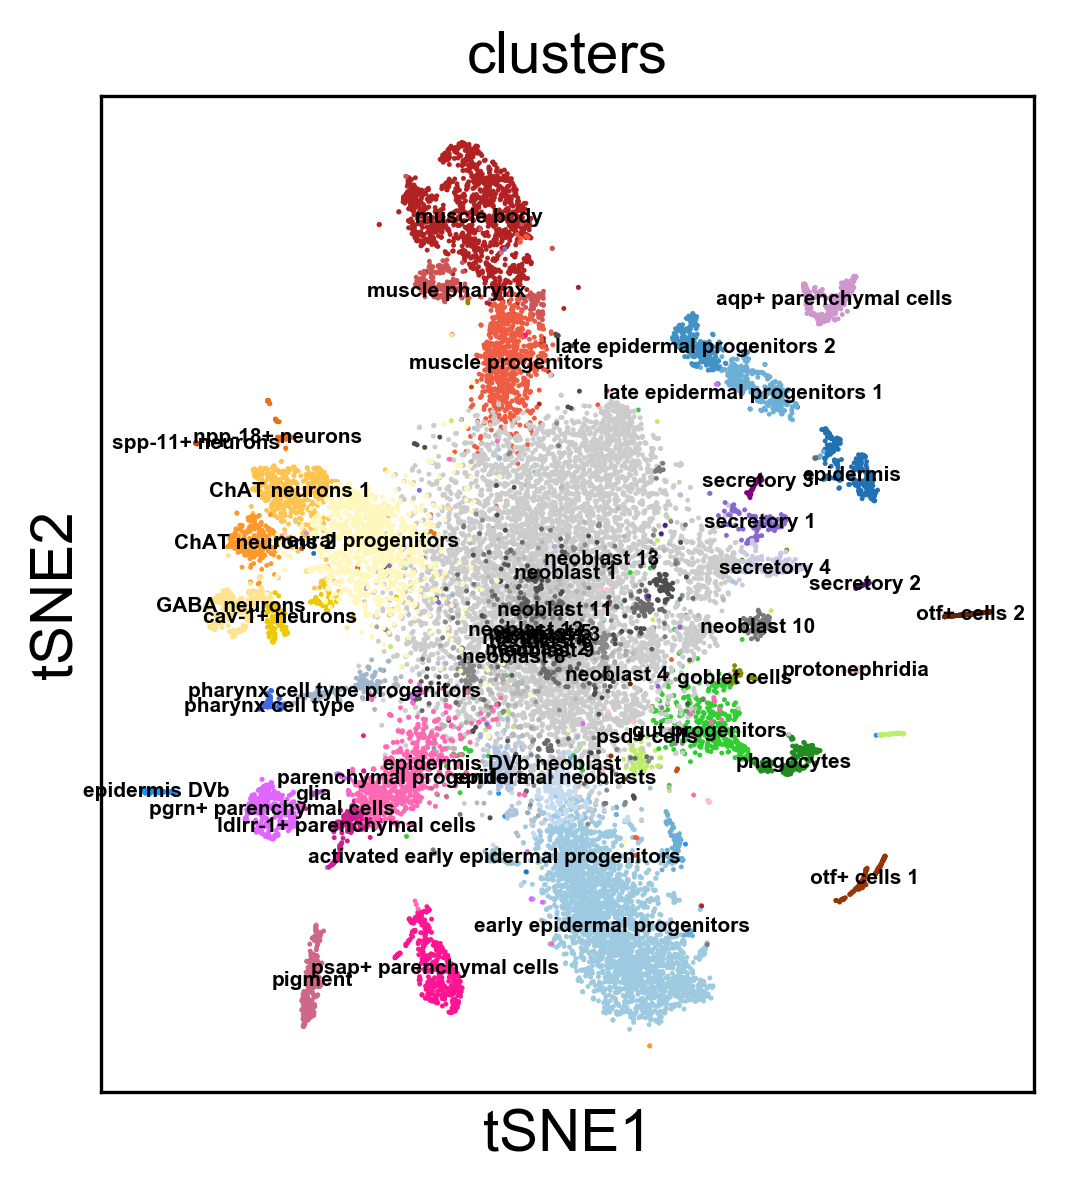

In [9]:
sc.pl.tsne(adata, color='clusters', legend_loc='on data', legend_fontsize=5, save='_full')

Let's save this.

In [10]:
adata.write(results_file)

**Note:** The next step is the only step that takes a long time to compute, you can safely skip this. It just demonstrates that graph drawing often is not able to provide a meaningful visualization out-of-the box.

In [9]:
# sc.pp.neighbors(adata, n_neighbors=30)
# sc.tl.draw_graph(adata)
# adata.write(results_file)

drawing single-cell graph using layout "fr"
    finished (0:51:25.332)


saving figure to file ./figures/draw_graph_fr_full.png


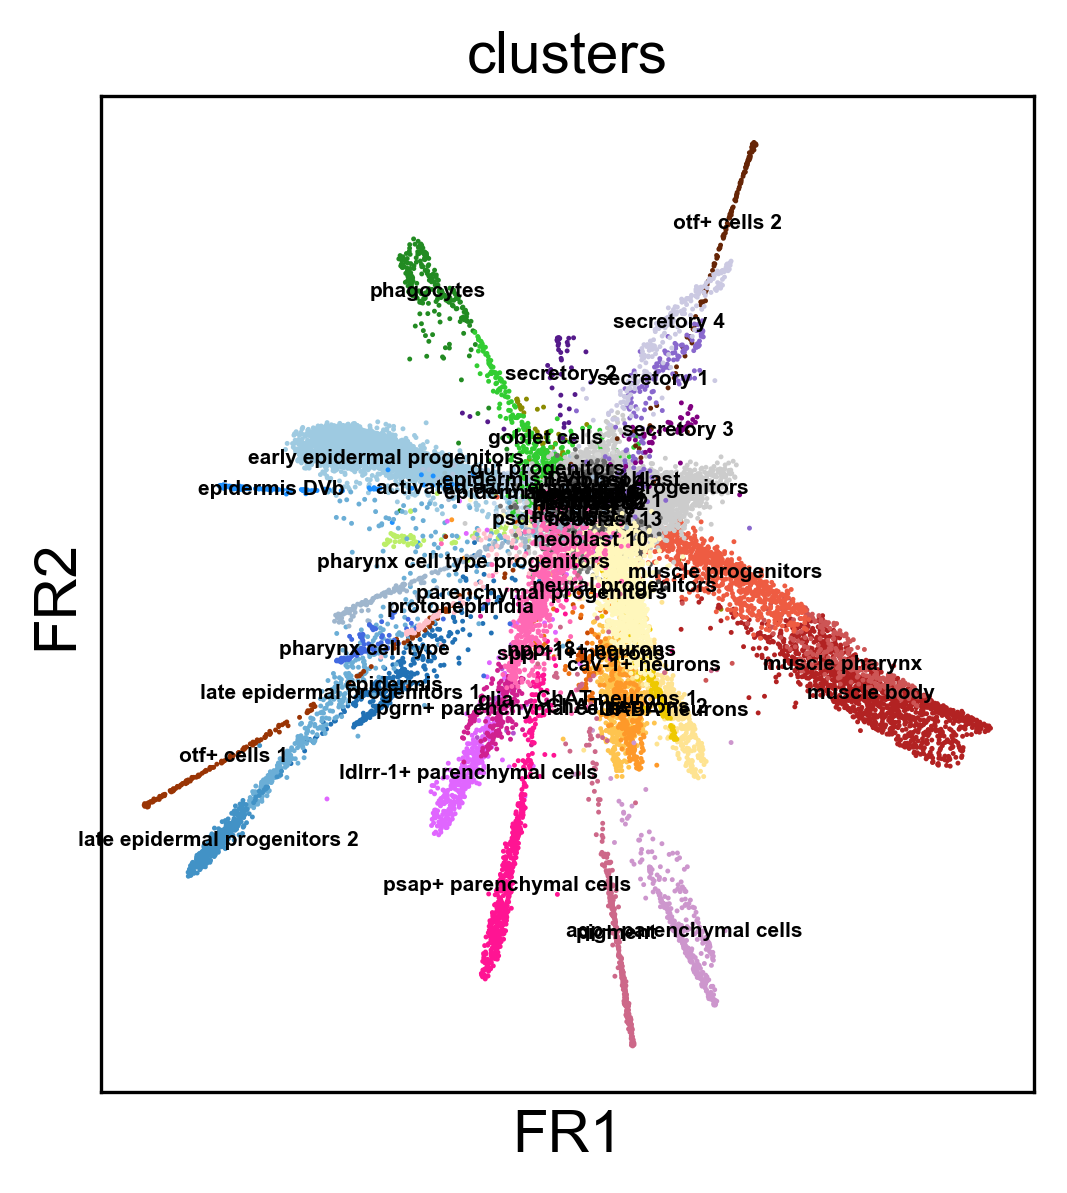

In [9]:
# adata = sc.read(results_file)
# sc.pl.draw_graph(adata, color='clusters', legend_loc='on data', legend_fontsize=5, save='_full')

## Cell map from PAGA

In [11]:
adata = sc.read(results_file)

In [17]:
sc.pp.neighbors(adata, n_neighbors=30)  # only need this if we didn't call it above already
sc.tl.paga(adata, groups='clusters')

computing neighbors
    using data matrix X directly
    finished (0:00:14.53)
running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:01.61)


saving figure to file ./figures/paga_compare_100percent.png


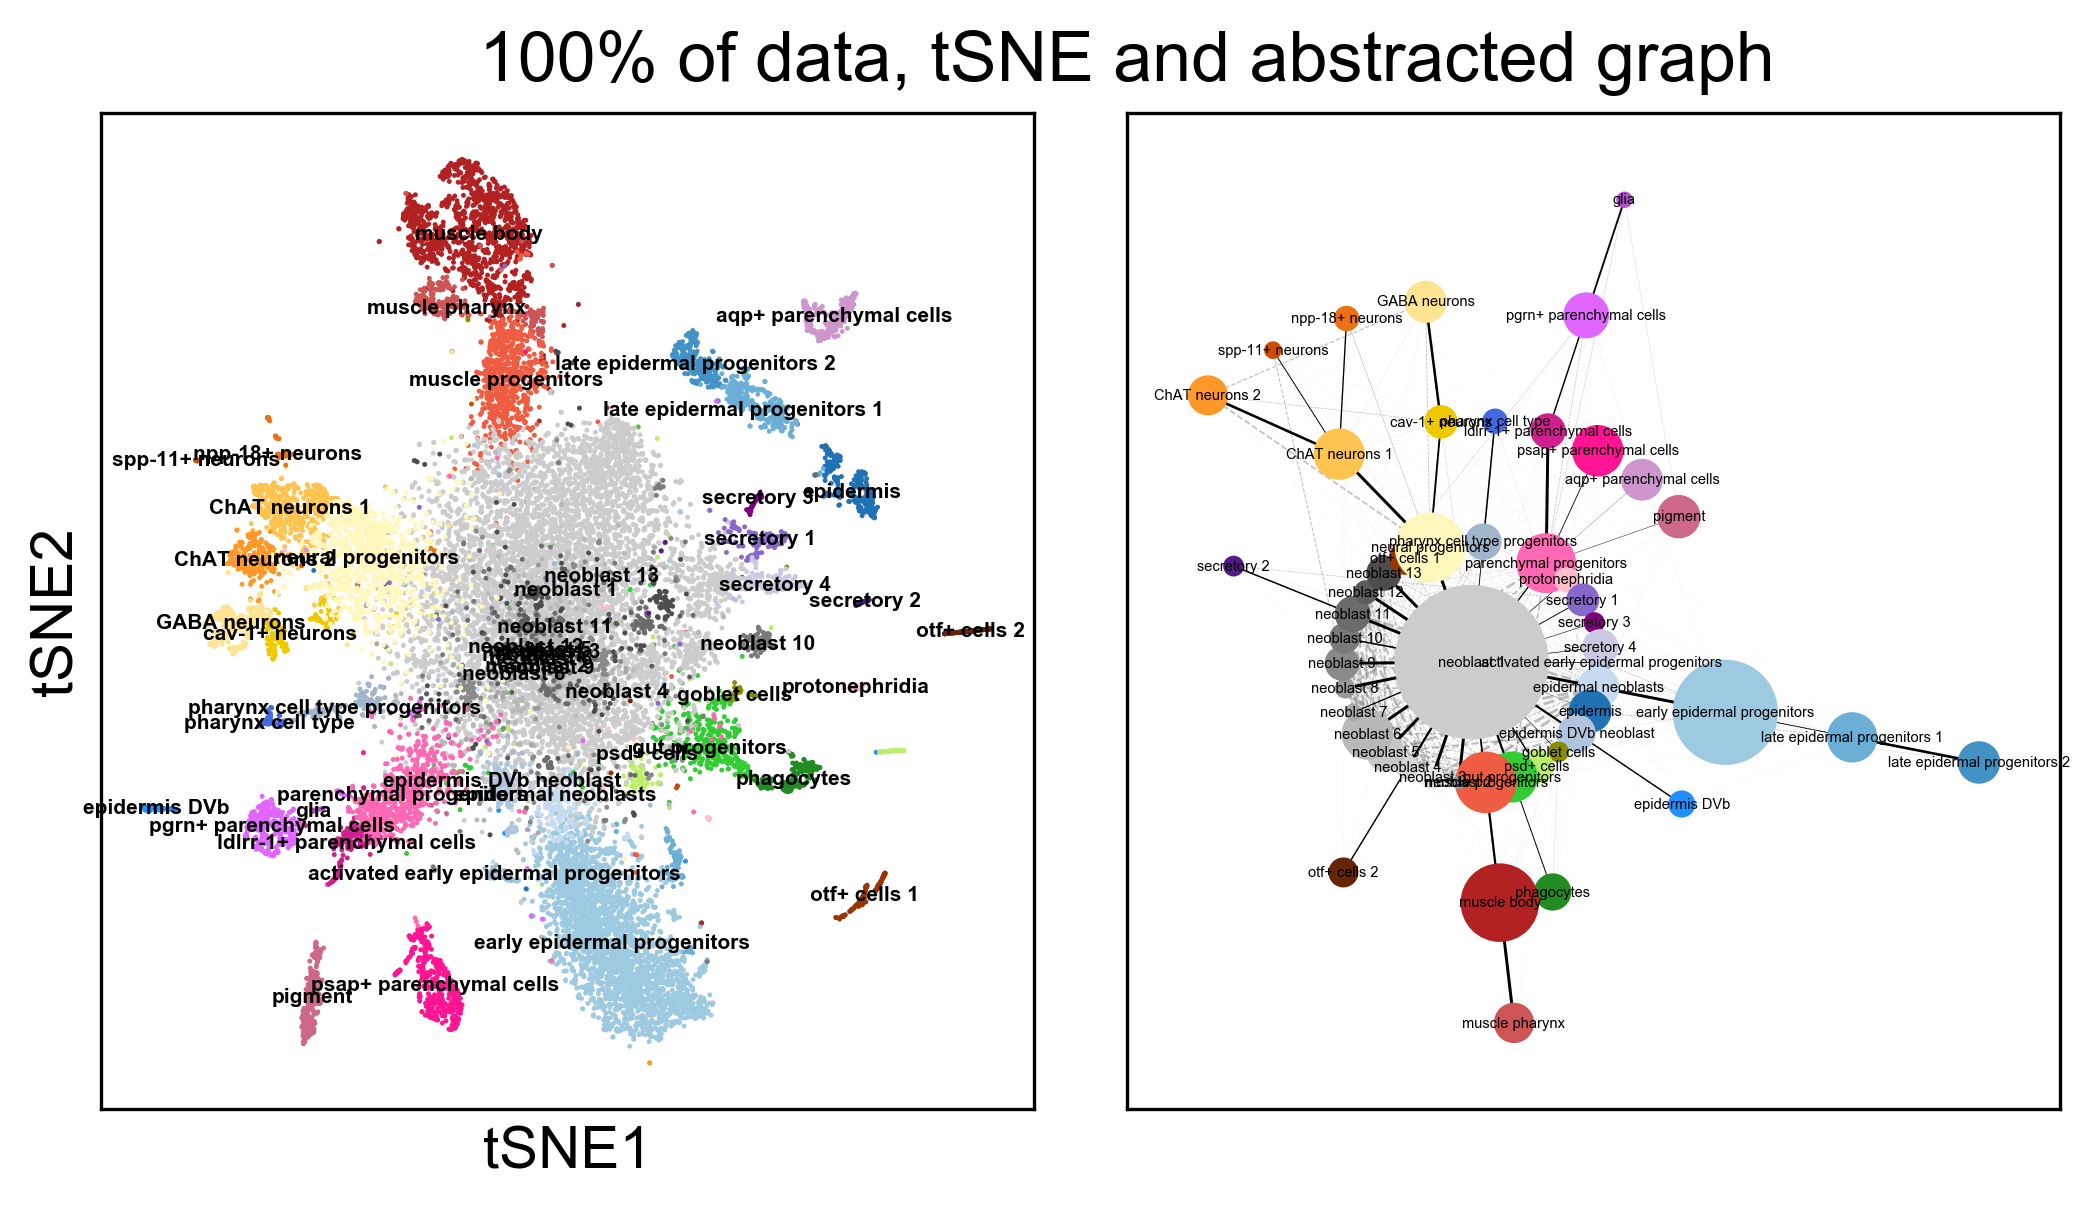

In [14]:
sc.pl.paga_compare(adata, title='100% of data, tSNE and abstracted graph', **paga_plot_params, save='_100percent')

In [18]:
adata.write(results_file)

## Pseudotime

Compute pseudotime: this is diffusion pseudotime of [Haghverdi *et al.* (2016)](https://doi.org/10.1038/nmeth.3971) in the extended implementation of PAGA [Wolf *et al.* (2017)](https://doi.org/10.1101/208819).

In [2]:
adata = sc.read(results_file)
# the following is not necessary for an almost-reproduction of the original pseudotime
# if you want the same results, recompute the graph with connectivities from method='gauss'
# sc.pp.neighbors(adata, method='gauss', n_neighbors=30)  

In [3]:
sc.tl.dpt(adata)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
    eigenvalues of transition matrix
    [ 1.            0.9976943731  0.9965093136  0.9964524508  0.9959484339
      0.9953794479  0.9947217107  0.9939476252  0.9936671853  0.9928948879]
    finished (0:00:02.45)


In [4]:
adata

AnnData object with n_obs × n_vars = 21612 × 50 
    obs: 'clusters', 'dpt_pseudotime'
    uns: 'clusters_colors', 'clusters_sizes', 'diffmap_evals', 'iroot', 'neighbors', 'paga'
    obsm: 'X_tsne', 'X_diffmap'

In [5]:
adata.write(results_file)

## Exports

Exports for external usage.

In [6]:
# generate a directory 'export'
!mkdir 'export'

mkdir: export: File exists


In [7]:
adata.obs[['clusters', 'dpt_pseudotime']].to_csv('./export_R_dataset/paga_groups_pseudotime.csv')
np.savetxt('./export_R_dataset/paga_groups_ordered_names.csv',
           adata.obs['clusters'].cat.categories, fmt='%s')
from scipy.io import mmwrite
mmwrite('./export/paga_adjacency_full.mtx', adata.uns['paga']['confidence'])
mmwrite('./export/paga_adjacency_tree.mtx', adata.uns['paga']['confidence_tree'])
entropies = sc.tl.paga_expression_entropies(adata)
np.savetxt('./export/paga_expression_entropies.txt', entropies)
degrees = sc.tl.paga_degrees(adata)
degrees = (degrees - np.min(degrees)) / (np.max(degrees) - np.min(degrees)) 
np.savetxt('./export/paga_degrees.txt', degrees)